In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import itertools

### 1.Load Dataset

In [ ]:
# Load CIFAR-10 dataset with data augmentation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

full_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainset, valset = torch.utils.data.random_split(full_trainset, [40000, 10000])
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
valloader = DataLoader(valset, batch_size=128, shuffle=False, num_workers=2)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)



100%|██████████| 170M/170M [00:05<00:00, 29.8MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### 2.EDA

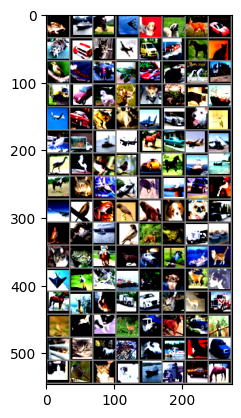

In [ ]:
# Exploratory Data Analysis (EDA)
# Visualize a few images from the dataset
import matplotlib.pyplot as plt

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))
# Print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [ ]:
# Dataset Statistics
train_data = np.concatenate([trainset[i][0].numpy().reshape(3, -1).T for i in range(len(trainset))], axis=0)
mean = np.mean(train_data, axis=0)
std = np.std(train_data, axis=0)
print(f"Dataset Mean: {mean}")
print(f"Dataset Std: {std}")

frog  ship  horse plane
Dataset Mean: [-0.3298161  -0.3372946  -0.31090513]
Dataset Std: [1.3985168 1.3939017 1.4155177]


<ipython-input-6-4a0b57b46b96>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Label', data=train_labels_df, palette='viridis')


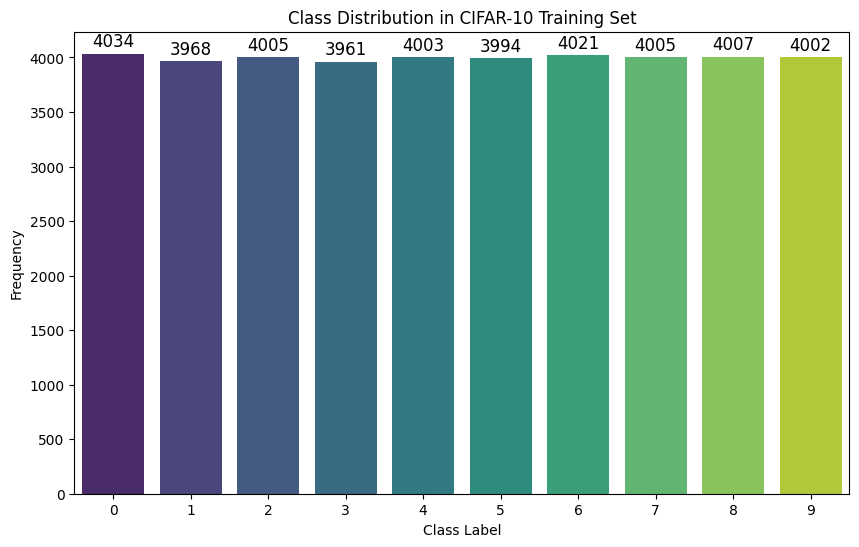

In [ ]:
# Plot class distribution
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

train_labels = [trainset[i][1] for i in range(len(trainset))]
train_labels_df = pd.DataFrame(train_labels, columns=['Label'])

plt.figure(figsize=(10, 6))
ax = sns.countplot(x='Label', data=train_labels_df, palette='viridis')

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.xlabel('Class Label')
plt.ylabel('Frequency')
plt.title('Class Distribution in CIFAR-10 Training Set')
plt.show()

### 3.Model

#### 3.1 SimpleCNN

In [ ]:
# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

#### 3.2 RestNet18

In [ ]:
# Function to build ResNet-18 model
def build_resnet18():
    model = models.resnet18(pretrained=False)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)  # Adjust for CIFAR-10 input size
    model.maxpool = nn.Identity()  # Remove the maxpool layer to better fit CIFAR-10
    model.fc = nn.Linear(model.fc.in_features, 10)
    return model

#### 3.3 MobileNetV2

In [ ]:
# Function to build MobileNetV2 model
def build_mobilenet_v2():
    model = models.mobilenet_v2(pretrained=False)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, 10)
    return model

#### 3.4 Function Defining

In [ ]:
# Function to train a model
def train_model(model, trainloader, valloader, criterion, optimizer, num_epochs=20):
    train_acc, val_acc = [], []
    best_val_acc = 0.0
    patience, wait = 5, 0
    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_accuracy = 100. * correct / total
        train_acc.append(train_accuracy)

        # Validation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_accuracy = 100. * correct / total
        val_acc.append(val_accuracy)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%')
      # Check for early stopping
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            wait = 0  # Reset wait counter if improvement is seen
        else:
            wait += 1  # Increment wait counter if no improvement

        if wait >= patience:
            print("Early stopping triggered")
            break

    return train_acc, val_acc

In [ ]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 4.Hyperparameter Tuning

In [ ]:
# Hyperparameter tuning for SimpleCNN
learning_rates_simplecnn = [0.001, 0.01, 0.1]
batch_sizes_simplecnn = [64, 128]
optimizers_simplecnn = ['SGD', 'Adam']

# Hyperparameter tuning for ResNet-18
learning_rates_resnet = [0.0001, 0.001, 0.01]
batch_sizes_resnet = [32, 64]
optimizers_resnet = ['SGD', 'Adam']

# Hyperparameter tuning for MobileNetV2
learning_rates_mobilenet = [0.0001, 0.001, 0.01]
batch_sizes_mobilenet = [32, 64]
optimizers_mobilenet = ['SGD', 'Adam']

In [ ]:
best_val_acc = 0
best_params = {}

for lr, batch_size, opt_name in itertools.product(learning_rates_simplecnn, batch_sizes_simplecnn, optimizers_simplecnn):
    print(f"Training SimpleCNN with learning rate: {lr}, batch size: {batch_size}, optimizer: {opt_name}")
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

    # Model: SimpleCNN
    model = SimpleCNN().to(device)
    if opt_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    elif opt_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_acc, val_acc = train_model(model, trainloader, valloader, criterion, optimizer, num_epochs=20)
    final_val_acc = val_acc[-1]

    if final_val_acc > best_val_acc:
        best_val_acc = final_val_acc
        best_params = {'learning_rate': lr, 'batch_size': batch_size, 'optimizer': opt_name}

print(f"Best Validation Accuracy: {best_val_acc}% with parameters: {best_params}")


Training SimpleCNN with learning rate: 0.001, batch size: 64, optimizer: SGD
Epoch [1/20], Train Acc: 21.08%, Val Acc: 29.37%
Epoch [2/20], Train Acc: 34.03%, Val Acc: 37.31%
Epoch [3/20], Train Acc: 40.15%, Val Acc: 40.81%
Epoch [4/20], Train Acc: 44.06%, Val Acc: 45.55%
Epoch [5/20], Train Acc: 46.97%, Val Acc: 47.08%
Epoch [6/20], Train Acc: 49.38%, Val Acc: 49.51%
Epoch [7/20], Train Acc: 52.04%, Val Acc: 51.73%
Epoch [8/20], Train Acc: 53.94%, Val Acc: 54.73%
Epoch [9/20], Train Acc: 56.06%, Val Acc: 56.94%
Epoch [10/20], Train Acc: 57.45%, Val Acc: 57.89%
Epoch [11/20], Train Acc: 59.81%, Val Acc: 58.89%
Epoch [12/20], Train Acc: 61.13%, Val Acc: 61.10%
Epoch [13/20], Train Acc: 62.25%, Val Acc: 62.26%
Epoch [14/20], Train Acc: 63.76%, Val Acc: 62.74%
Epoch [15/20], Train Acc: 65.04%, Val Acc: 64.68%
Epoch [16/20], Train Acc: 66.15%, Val Acc: 64.89%
Epoch [17/20], Train Acc: 67.18%, Val Acc: 66.85%
Epoch [18/20], Train Acc: 67.87%, Val Acc: 67.55%
Epoch [19/20], Train Acc: 68.62%

In [ ]:
# Simple CNN
model1 = SimpleCNN().to(device)
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
print("Training Simple CNN...")
train_acc1, val_acc1 = train_model(model1, trainloader, valloader, criterion, optimizer1)

Training Simple CNN...
Epoch [1/10], Train Acc: 40.37%, Val Acc: 49.42%
Epoch [2/10], Train Acc: 53.81%, Val Acc: 57.56%
Epoch [3/10], Train Acc: 60.94%, Val Acc: 62.03%
Epoch [4/10], Train Acc: 65.48%, Val Acc: 67.64%
Epoch [5/10], Train Acc: 68.63%, Val Acc: 69.86%
Epoch [6/10], Train Acc: 71.16%, Val Acc: 70.77%
Epoch [7/10], Train Acc: 72.89%, Val Acc: 72.03%
Epoch [8/10], Train Acc: 74.26%, Val Acc: 72.55%
Epoch [9/10], Train Acc: 76.03%, Val Acc: 73.01%
Epoch [10/10], Train Acc: 76.66%, Val Acc: 74.83%


In [ ]:
# Hyperparameter tuning for ResNet-18
best_val_acc_resnet = 0
best_params_resnet = {}
for lr, batch_size, opt_name in itertools.product(learning_rates_resnet, batch_sizes_resnet, optimizers_resnet):
    print(f"Training ResNet-18 with learning rate: {lr}, batch size: {batch_size}, optimizer: {opt_name}")
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    valloader = DataLoader(valset, batch_size=128, shuffle=False, num_workers=2)
    model2 = build_resnet18().to(device)
    if opt_name == 'SGD':
        optimizer2 = optim.SGD(model2.parameters(), lr=lr, momentum=0.9)
    elif opt_name == 'Adam':
        optimizer2 = optim.Adam(model2.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    train_acc_resnet, val_acc_resnet = train_model(model2, trainloader, valloader, criterion, optimizer2, num_epochs=20)
    final_val_acc_resnet = val_acc_resnet[-1]
    if final_val_acc_resnet > best_val_acc_resnet:
        best_val_acc_resnet = final_val_acc_resnet
        best_params_resnet = {'learning_rate': lr, 'batch_size': batch_size, 'optimizer': opt_name}
print(f"Best Validation Accuracy for ResNet-18: {best_val_acc_resnet}% with parameters: {best_params_resnet}")

model2 = build_resnet18().to(device)
optimizer2 = optim.Adam(model2.parameters(), lr=best_params_resnet['learning_rate'])
print("Training ResNet-18...")
train_acc2, val_acc2 = train_model(model2, trainloader, valloader, criterion, optimizer2)

Training ResNet-18 with learning rate: 0.0001, batch size: 32, optimizer: SGD


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/20], Train Acc: 23.49%, Val Acc: 29.99%
Epoch [2/20], Train Acc: 32.92%, Val Acc: 35.23%
Epoch [3/20], Train Acc: 36.97%, Val Acc: 37.85%
Epoch [4/20], Train Acc: 39.44%, Val Acc: 39.67%
Epoch [5/20], Train Acc: 41.79%, Val Acc: 42.99%
Epoch [6/20], Train Acc: 43.90%, Val Acc: 45.43%
Epoch [7/20], Train Acc: 45.67%, Val Acc: 46.82%
Epoch [8/20], Train Acc: 47.76%, Val Acc: 48.54%
Epoch [9/20], Train Acc: 49.69%, Val Acc: 50.17%
Epoch [10/20], Train Acc: 50.94%, Val Acc: 51.81%
Epoch [11/20], Train Acc: 52.45%, Val Acc: 53.49%
Epoch [12/20], Train Acc: 53.84%, Val Acc: 54.96%
Epoch [13/20], Train Acc: 54.96%, Val Acc: 56.90%
Epoch [14/20], Train Acc: 56.09%, Val Acc: 56.80%
Epoch [15/20], Train Acc: 57.14%, Val Acc: 58.42%
Epoch [16/20], Train Acc: 58.30%, Val Acc: 57.44%
Epoch [17/20], Train Acc: 59.18%, Val Acc: 60.63%
Epoch [18/20], Train Acc: 60.27%, Val Acc: 61.32%
Epoch [19/20], Train Acc: 61.35%, Val Acc: 61.67%
Epoch [20/20], Train Acc: 62.52%, Val Acc: 63.15%
Training 

In [ ]:
# Hyperparameter tuning for MobileNetV2
best_val_acc_mobilenet = 0
best_params_mobilenet = {}
for lr, batch_size, opt_name in itertools.product(learning_rates_mobilenet, batch_sizes_mobilenet, optimizers_mobilenet):
    print(f"Training MobileNetV2 with learning rate: {lr}, batch size: {batch_size}, optimizer: {opt_name}")
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)
    valloader = DataLoader(valset, batch_size=128, shuffle=False, num_workers=4)
    model3 = build_mobilenet_v2().to(device)
    if opt_name == 'SGD':
        optimizer3 = optim.SGD(model3.parameters(), lr=lr, momentum=0.9)
    elif opt_name == 'Adam':
        optimizer3 = optim.Adam(model3.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    train_acc_mobilenet, val_acc_mobilenet = train_model(model3, trainloader, valloader, criterion, optimizer3, num_epochs=20)
    final_val_acc_mobilenet = val_acc_mobilenet[-1]
    if final_val_acc_mobilenet > best_val_acc_mobilenet:
        best_val_acc_mobilenet = final_val_acc_mobilenet
        best_params_mobilenet = {'learning_rate': lr, 'batch_size': batch_size, 'optimizer': opt_name}
print(f"Best Validation Accuracy for MobileNetV2: {best_val_acc_mobilenet}% with parameters: {best_params_mobilenet}")

model3 = build_mobilenet_v2().to(device)
optimizer3 = optim.Adam(model3.parameters(), lr=best_params_mobilenet['learning_rate'])
print("Training MobileNetV2...")
train_acc3, val_acc3 = train_model(model3, trainloader, valloader, criterion, optimizer3)

Training MobileNetV2 with learning rate: 0.0001, batch size: 32, optimizer: SGD
Epoch [1/20], Train Acc: 13.22%, Val Acc: 17.35%
Epoch [2/20], Train Acc: 19.42%, Val Acc: 23.85%
Epoch [3/20], Train Acc: 24.17%, Val Acc: 26.02%
Epoch [4/20], Train Acc: 26.70%, Val Acc: 29.35%
Epoch [5/20], Train Acc: 28.79%, Val Acc: 31.23%
Epoch [6/20], Train Acc: 31.16%, Val Acc: 32.49%
Epoch [7/20], Train Acc: 32.81%, Val Acc: 34.68%
Epoch [8/20], Train Acc: 34.19%, Val Acc: 35.91%
Epoch [9/20], Train Acc: 35.56%, Val Acc: 37.25%
Epoch [10/20], Train Acc: 36.44%, Val Acc: 38.18%
Epoch [11/20], Train Acc: 37.56%, Val Acc: 39.54%
Epoch [12/20], Train Acc: 38.48%, Val Acc: 40.62%
Epoch [13/20], Train Acc: 39.44%, Val Acc: 41.54%
Epoch [14/20], Train Acc: 40.22%, Val Acc: 42.76%
Epoch [15/20], Train Acc: 40.67%, Val Acc: 42.12%
Epoch [16/20], Train Acc: 41.29%, Val Acc: 43.28%
Epoch [17/20], Train Acc: 42.20%, Val Acc: 44.17%
Epoch [18/20], Train Acc: 43.03%, Val Acc: 44.63%
Epoch [19/20], Train Acc: 42.

In [ ]:
# Plotting accuracy curves
def plot_accuracy(train_acc, val_acc, title="Model Accuracy"):
    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title(title)
    plt.legend()
    plt.show()


### 5.Implement in Test Set

#### 5.1 Simple CNN

In [ ]:
# Apply best parameters to test set and evaluate
# Simple CNN
model1 = SimpleCNN().to(device)
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
model1.eval()
correct, total = 0, 0
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model1(inputs)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
test_accuracy_simplecnn = 100. * correct / total
print(f"Test Accuracy for SimpleCNN with Best Parameters: {test_accuracy_simplecnn:.2f}%")

Test Accuracy for SimpleCNN with Best Parameters: 10.93%


#### 5.2 RestNet-18

In [ ]:
# ResNet-18
model2 = build_resnet18().to(device)

optimizer2 = optim.Adam(model2.parameters(), lr=0.001)
model2.eval()
correct, total = 0, 0
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model2(inputs)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
test_accuracy_resnet = 100. * correct / total
print(f"Test Accuracy for ResNet-18 with Best Parameters: {test_accuracy_resnet:.2f}%")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Test Accuracy for ResNet-18 with Best Parameters: 10.26%


#### 5.3 MobileNetV2

In [ ]:
# MobileNetV2
model3 = build_mobilenet_v2().to(device)

optimizer3 = optim.Adam(model3.parameters(), lr=0.001)
model3.eval()
correct, total = 0, 0
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model3(inputs)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
test_accuracy_mobilenet = 100. * correct / total
print(f"Test Accuracy for MobileNetV2 with Best Parameters: {test_accuracy_mobilenet:.2f}%")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Test Accuracy for MobileNetV2 with Best Parameters: 10.00%


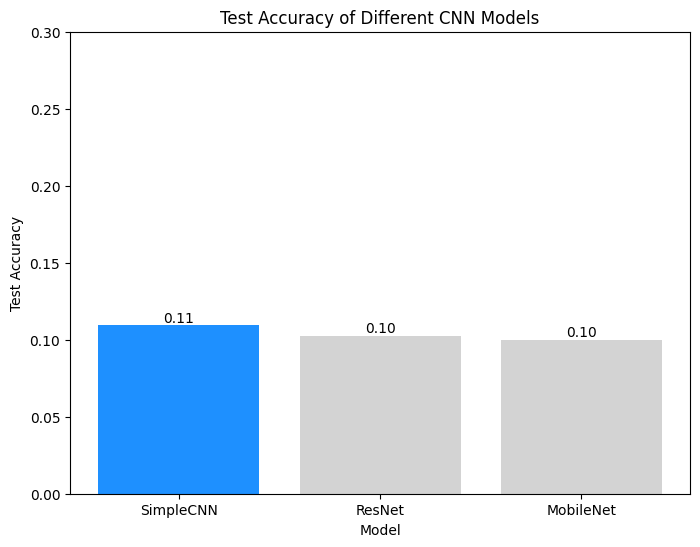

In [ ]:
# Labels and data for the bar chart
models = ['SimpleCNN', 'ResNet', 'MobileNet']
accuracies = [10.93/100, 10.26/100, 10.00/100]
# Determine colors based on the highest accuracy
colors = ['lightgray' if acc < max(accuracies) else 'dodgerblue' for acc in accuracies]

# Plotting the bar chart with customized colors and labels
plt.figure(figsize=(8, 6))
bars = plt.bar(models, accuracies, color=colors)
plt.title('Test Accuracy of Different CNN Models')
plt.xlabel('Model')
plt.ylabel('Test Accuracy')
plt.ylim(0, 0.3)

# Adding data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f"{yval:.2f}", ha='center', va='bottom')

plt.show()

### 6.Reduce Overfitting

In [ ]:
from sklearn.metrics import recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

def train_model_new(model, trainloader, valloader, criterion, optimizer, num_epochs=50):
    train_acc, val_acc, train_loss_curve = [], [], []  # Add list to store training loss
    best_val_acc = 0.0
    patience, wait = 5, 0
    final_cm = None  # Variable to store the final confusion matrix

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        # Calculate average loss for the epoch
        avg_train_loss = running_loss / len(trainloader)
        train_loss_curve.append(avg_train_loss)

        train_accuracy = 100. * correct / total
        train_acc.append(train_accuracy)

        # Validation
        model.eval()
        correct, total = 0, 0
        all_labels, all_preds = [], []  # Lists to store all labels and predictions for metrics
        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                # Collect all predictions and labels for metric calculation
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())

        val_accuracy = 100. * correct / total
        val_acc.append(val_accuracy)

        # Calculate recall, F1, and confusion matrix
        recall = recall_score(all_labels, all_preds, average='macro') * 100
        f1 = f1_score(all_labels, all_preds, average='macro') * 100
        final_cm = confusion_matrix(all_labels, all_preds)  # Store the final confusion matrix

        # Print metrics for the epoch
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%, Recall: {recall:.2f}%, F1: {f1:.2f}%')

        # Check for early stopping
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            wait = 0  # Reset wait counter if improvement is seen
        else:
            wait += 1  # Increment wait counter if no improvement

        if wait >= patience:
            print("Early stopping triggered")
            break

    # Plot the loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_loss_curve) + 1), train_loss_curve, label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot the final confusion matrix as a heatmap
    plt.figure(figsize=(10, 7))
    sns.heatmap(final_cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    return train_acc, val_acc

#### 6.1 Simple CNN

Training SimpleCNN with weight decay...
Epoch [1/50], Train Loss: 1.6112, Train Acc: 40.87%, Val Acc: 49.95%, Recall: 49.88%, F1: 49.64%
Epoch [2/50], Train Loss: 1.2305, Train Acc: 55.77%, Val Acc: 58.67%, Recall: 58.68%, F1: 58.43%
Epoch [3/50], Train Loss: 1.0616, Train Acc: 62.33%, Val Acc: 64.81%, Recall: 64.95%, F1: 64.31%
Epoch [4/50], Train Loss: 0.9379, Train Acc: 66.82%, Val Acc: 67.45%, Recall: 67.55%, F1: 67.26%
Epoch [5/50], Train Loss: 0.8611, Train Acc: 69.88%, Val Acc: 69.67%, Recall: 69.77%, F1: 69.15%
Epoch [6/50], Train Loss: 0.7992, Train Acc: 71.96%, Val Acc: 69.94%, Recall: 70.05%, F1: 69.55%
Epoch [7/50], Train Loss: 0.7652, Train Acc: 73.02%, Val Acc: 71.64%, Recall: 71.72%, F1: 71.52%
Epoch [8/50], Train Loss: 0.7144, Train Acc: 74.88%, Val Acc: 74.24%, Recall: 74.26%, F1: 74.19%
Epoch [9/50], Train Loss: 0.6861, Train Acc: 75.86%, Val Acc: 74.13%, Recall: 74.15%, F1: 74.32%
Epoch [10/50], Train Loss: 0.6681, Train Acc: 76.59%, Val Acc: 75.09%, Recall: 75.16%, 

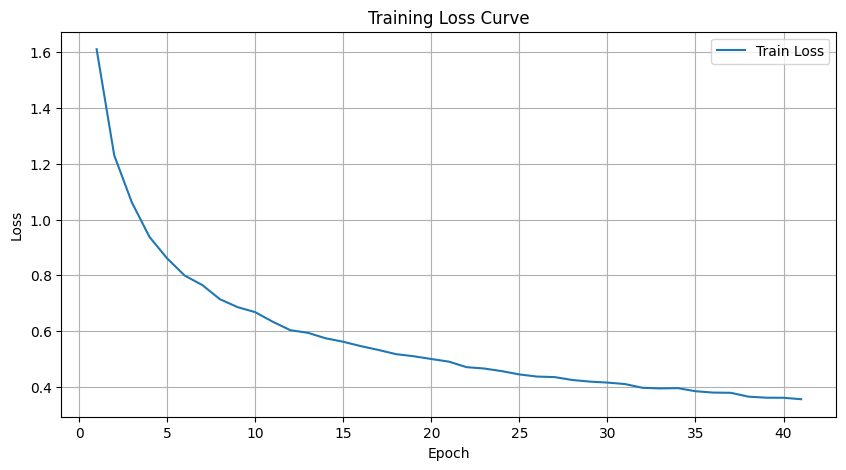

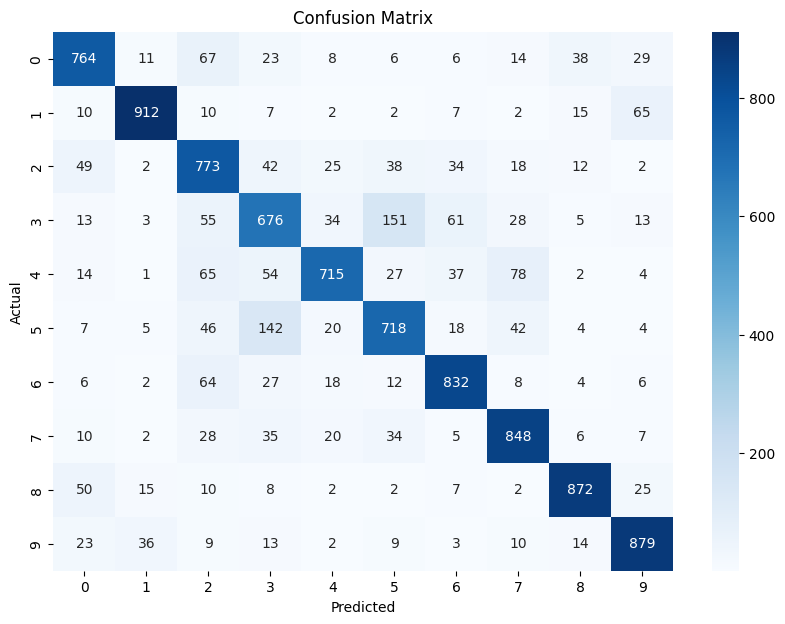

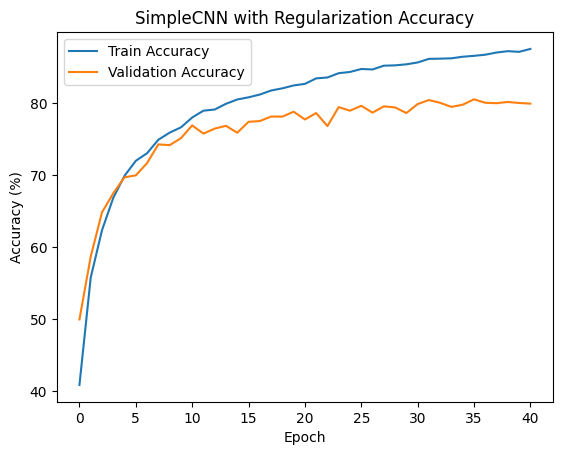

In [ ]:
criterion = nn.CrossEntropyLoss()
# SimpleCNN with regularization
model1_new = SimpleCNN().to(device)
optimizer1_new = optim.Adam(model1_new.parameters(), lr=0.001, weight_decay=1e-4)
trainloader1_new = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
print("Training SimpleCNN with weight decay...")
train_acc1_new, val_acc1_new = train_model_new(model1_new, trainloader1_new, valloader, criterion, optimizer1_new)
plot_accuracy(train_acc1_new, val_acc1_new, title="SimpleCNN with Regularization Accuracy")

#### 6.2 RestNet-18

Training ResNet-18 with weight decay...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/50], Train Loss: 1.4441, Train Acc: 47.40%, Val Acc: 55.41%, Recall: 55.39%, F1: 53.97%
Epoch [2/50], Train Loss: 1.0108, Train Acc: 64.28%, Val Acc: 64.61%, Recall: 64.67%, F1: 64.88%
Epoch [3/50], Train Loss: 0.8332, Train Acc: 71.22%, Val Acc: 66.29%, Recall: 66.43%, F1: 66.49%
Epoch [4/50], Train Loss: 0.7208, Train Acc: 75.04%, Val Acc: 76.16%, Recall: 76.26%, F1: 75.59%
Epoch [5/50], Train Loss: 0.6512, Train Acc: 77.45%, Val Acc: 76.98%, Recall: 77.03%, F1: 76.80%
Epoch [6/50], Train Loss: 0.5881, Train Acc: 79.88%, Val Acc: 79.58%, Recall: 79.55%, F1: 79.70%
Epoch [7/50], Train Loss: 0.5412, Train Acc: 81.61%, Val Acc: 81.32%, Recall: 81.37%, F1: 81.28%
Epoch [8/50], Train Loss: 0.5053, Train Acc: 82.79%, Val Acc: 79.82%, Recall: 79.87%, F1: 79.41%
Epoch [9/50], Train Loss: 0.4712, Train Acc: 83.94%, Val Acc: 83.97%, Recall: 84.03%, F1: 83.88%
Epoch [10/50], Train Loss: 0.4463, Train Acc: 84.83%, Val Acc: 81.75%, Recall: 81.84%, F1: 81.53%
Epoch [11/50], Train Loss: 0.

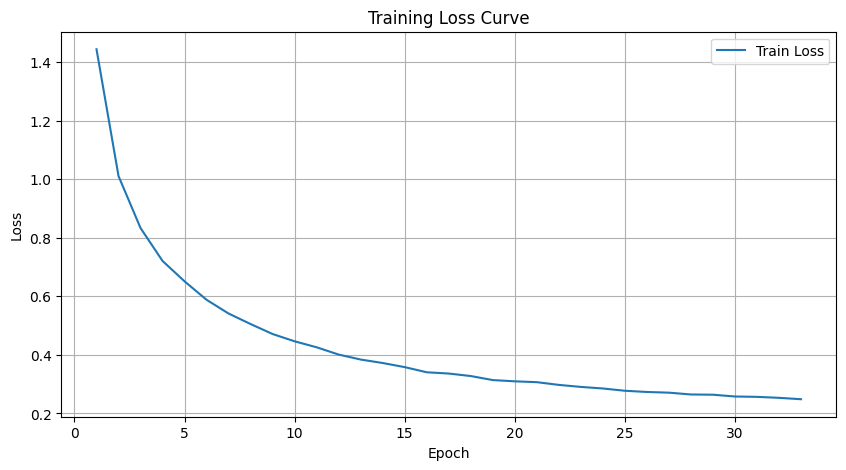

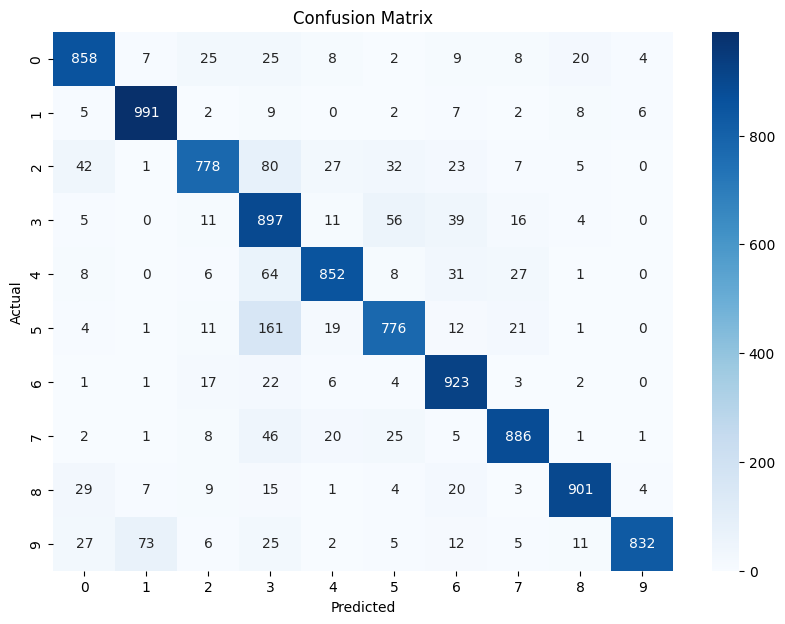

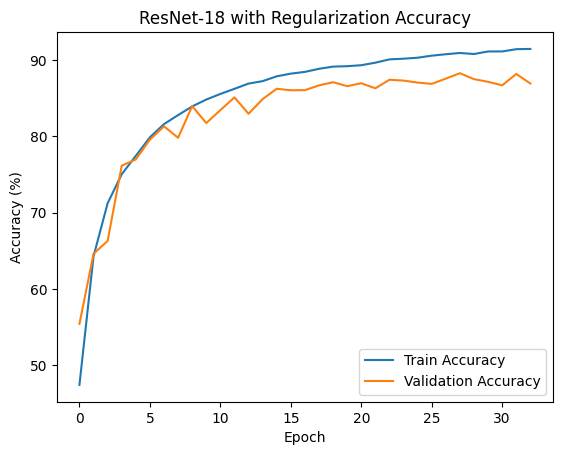

In [ ]:
# ResNet-18 with regularization
model2_new = build_resnet18().to(device)
optimizer2_new = optim.Adam(model2_new.parameters(), lr=0.001, weight_decay=1e-4)
trainloader2_new = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)
print("Training ResNet-18 with weight decay...")
train_acc2_new, val_acc2_new = train_model_new(model2_new, trainloader2_new, valloader, criterion, optimizer2_new)
plot_accuracy(train_acc2_new, val_acc2_new, title="ResNet-18 with Regularization Accuracy")

#### 6.3 MobileNetV2

Training MobileNetV2 with weight decay...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/50], Train Loss: 2.0574, Train Acc: 23.78%, Val Acc: 31.33%, Recall: 31.41%, F1: 28.02%
Epoch [2/50], Train Loss: 1.7194, Train Acc: 35.93%, Val Acc: 39.14%, Recall: 39.12%, F1: 37.52%
Epoch [3/50], Train Loss: 1.5976, Train Acc: 41.63%, Val Acc: 44.60%, Recall: 44.63%, F1: 43.14%
Epoch [4/50], Train Loss: 1.4881, Train Acc: 46.13%, Val Acc: 48.20%, Recall: 48.09%, F1: 47.77%
Epoch [5/50], Train Loss: 1.3975, Train Acc: 49.74%, Val Acc: 52.05%, Recall: 52.07%, F1: 51.49%
Epoch [6/50], Train Loss: 1.3128, Train Acc: 53.22%, Val Acc: 56.19%, Recall: 56.24%, F1: 56.14%
Epoch [7/50], Train Loss: 1.2380, Train Acc: 56.03%, Val Acc: 56.98%, Recall: 57.03%, F1: 57.09%
Epoch [8/50], Train Loss: 1.1794, Train Acc: 58.57%, Val Acc: 58.57%, Recall: 58.76%, F1: 58.11%
Epoch [9/50], Train Loss: 1.1169, Train Acc: 60.69%, Val Acc: 61.84%, Recall: 61.98%, F1: 61.60%
Epoch [10/50], Train Loss: 1.0716, Train Acc: 62.37%, Val Acc: 61.96%, Recall: 62.13%, F1: 60.63%
Epoch [11/50], Train Loss: 1.

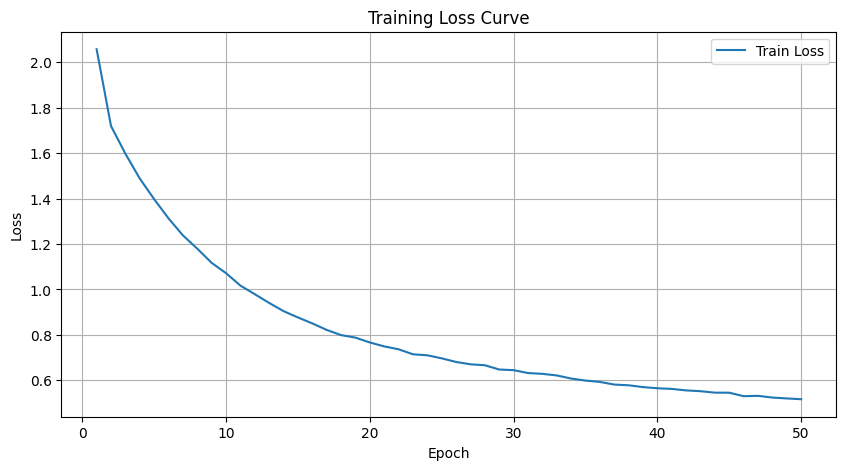

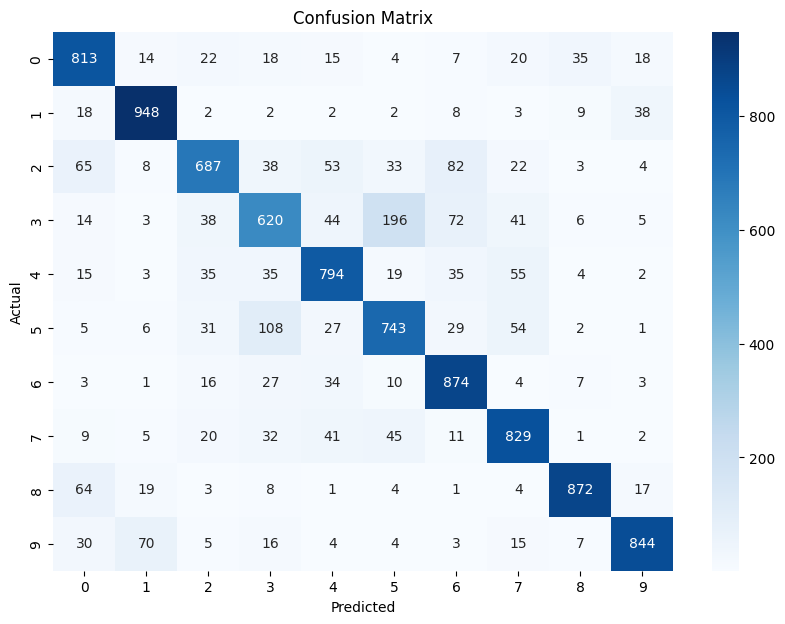

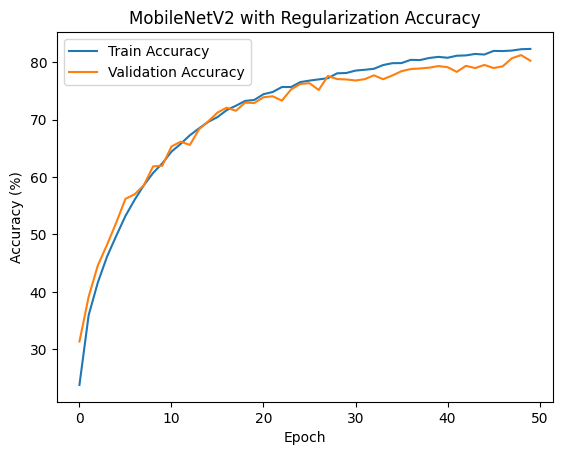

In [ ]:
# MobileNetV2 with regularization
model3_new = build_mobilenet_v2().to(device)
optimizer3_new = optim.Adam(model3_new.parameters(), lr=0.001, weight_decay=1e-4)
trainloader3_new = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
print("Training MobileNetV2 with weight decay...")
train_acc3_new, val_acc3_new = train_model_new(model3_new, trainloader3_new, valloader, criterion, optimizer3_new)
plot_accuracy(train_acc3_new, val_acc3_new, title="MobileNetV2 with Regularization Accuracy")

#### 6.4 Implement in Test set

In [ ]:
# SimpleCNN on test set
model1_new.eval()
correct, total = 0, 0
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model1_new(inputs)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
test_accuracy_simplecnn = 100. * correct / total
print(f"Test Accuracy for SimpleCNN with Regularization: {test_accuracy_simplecnn:.2f}%")

Test Accuracy for SimpleCNN with Regularization: 82.68%


In [ ]:
# ResNet-18 on test set
model2_new.eval()
correct, total = 0, 0
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model2_new(inputs)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
test_accuracy_resnet = 100. * correct / total
print(f"Test Accuracy for ResNet-18 with Regularization: {test_accuracy_resnet:.2f}%")

Test Accuracy for ResNet-18 with Regularization: 87.55%


In [ ]:
# MobileNetV2 on test set
model3_new.eval()
correct, total = 0, 0
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model3_new(inputs)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
test_accuracy_mobilenet = 100. * correct / total
print(f"Test Accuracy for MobileNetV2 with Regularization: {test_accuracy_mobilenet:.2f}%")

Test Accuracy for MobileNetV2 with Regularization: 81.87%


### 7.Result

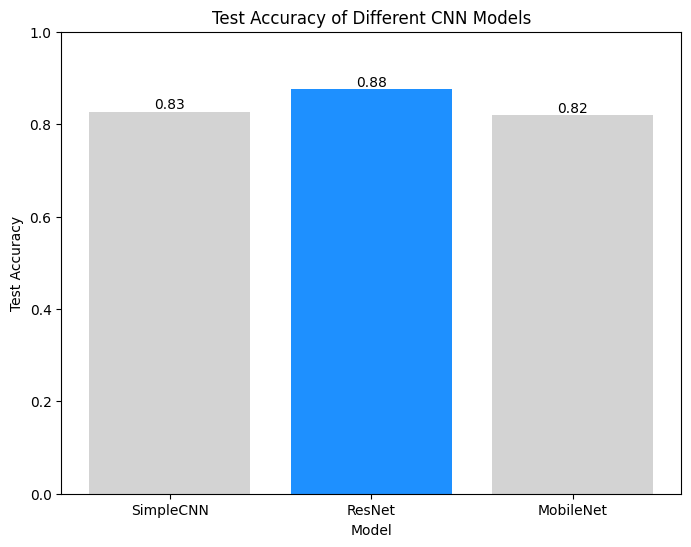

In [ ]:
# Labels and data for the bar chart
models = ['SimpleCNN', 'ResNet', 'MobileNet']
accuracies = [test_accuracy_simplecnn/100, test_accuracy_resnet/100, test_accuracy_mobilenet/100]
# Determine colors based on the highest accuracy
colors = ['lightgray' if acc < max(accuracies) else 'dodgerblue' for acc in accuracies]

# Plotting the bar chart with customized colors and labels
plt.figure(figsize=(8, 6))
bars = plt.bar(models, accuracies, color=colors)
plt.title('Test Accuracy of Different CNN Models')
plt.xlabel('Model')
plt.ylabel('Test Accuracy')
plt.ylim(0, 1)

# Adding data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f"{yval:.2f}", ha='center', va='bottom')

plt.show()
